# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [42]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [43]:
from lib.dataeng import Etl

In [44]:
etl = Etl()
etl.repo

'/home/benjamin/Downloads/'

In [45]:
df_weight_raw = etl._extract_poids() # extrait toutes les mesures de poids

Le fichier poids le plus récent est : data_BEN_1706761334.zip, parmi :

data_BEN_1706593344.zip
data_BEN_1706676305.zip
data_BEN_1706761334.zip


In [46]:
df_weight = df_weight_raw.groupby(['Date']).mean()

In [47]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-01-18,73.055000,12.607500,3.020000,57.414167,40.441667,0.172574,1675.666000
2024-01-19,72.494167,12.419167,3.002500,57.056667,40.122500,0.171311,1667.620000
2024-01-20,72.846667,12.586667,3.010833,57.232500,40.268333,0.172782,1671.616000
2024-01-21,72.544167,12.618333,2.994167,56.915833,39.952500,0.173940,1664.398000
2024-01-22,72.324167,12.001667,3.015833,57.290000,40.426667,0.165943,1672.966000
2024-01-23,72.640000,12.190833,3.021667,57.413333,40.515000,0.167824,1675.702000
2024-01-24,72.864167,12.309167,3.028333,57.512500,40.590833,0.168932,1677.988000
2024-01-25,73.599167,12.578333,3.049167,57.956667,40.979167,0.170902,1688.050000
2024-01-26,73.905833,12.539167,3.069167,58.285833,41.313333,0.169663,1695.520000


In [48]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-01-18,72.607875,12.415586,3.007976,57.169496,40.233590,0.170995,1670.153451
2024-01-19,72.569304,12.458681,3.003810,57.092234,40.149423,0.171678,1668.389451
2024-01-20,72.609304,12.478562,3.004881,57.111044,40.165137,0.171857,1668.824022
2024-01-21,72.606447,12.519515,3.002262,57.069258,40.117756,0.172428,1667.877736
2024-01-22,72.605137,12.439634,3.006548,57.143425,40.204542,0.171327,1669.574879
2024-01-23,72.611804,12.394991,3.009286,57.192115,40.260733,0.170697,1670.683165
2024-01-24,72.681190,12.390476,3.013333,57.262143,40.331071,0.170472,1672.279429
2024-01-25,72.758929,12.386310,3.017500,57.339643,40.407857,0.170233,1674.048571
2024-01-26,72.960595,12.403452,3.027024,57.515238,40.577976,0.169998,1678.034286


In [49]:
df_food_raw = etl._extract_food()  # calories par jour par repas

Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-02-01.zip, parmi 

File-Export-2020-08-03-to-2024-02-01.zip
File-Export-2020-08-03-to-2024-01-31.zip
File-Export-2020-08-03-to-2024-01-30.zip


In [50]:
df_food = df_food_raw.groupby(['Date']).sum(numeric_only=True)

In [51]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2024-01-17,1637.2,29.5,174.6,183.0
2024-01-18,1661.5,41.4,124.4,194.5
2024-01-19,1671.0,37.5,153.5,187.8
2024-01-20,1771.0,64.7,133.0,168.3
2024-01-21,2014.0,71.0,165.3,184.7
2024-01-22,1714.6,40.0,160.6,179.2
2024-01-23,1656.9,31.3,159.7,180.5
2024-01-24,1731.9,23.8,191.2,195.0
2024-01-25,1803.3,37.1,164.0,214.8


In [52]:
df_exos_raw = etl._extract_exos()

Le fichier exercices le plus récent est : polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip, parmi :

polar-user-data-export_12baa4ce-79a5-40f8-ad40-74308f7c2c26.zip
polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip


100%|██████████| 1868/1868 [01:03<00:00, 29.44it/s]


In [53]:
df_exos_total = df_exos_raw.groupby(['exo_date']).sum(numeric_only=True)

In [54]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-01-17,1920.874,202.0
2024-01-18,0.000,0.0
2024-01-19,3480.703,399.0
2024-01-20,3240.721,478.0
2024-01-21,1980.703,336.0
2024-01-22,3180.829,369.0
2024-01-23,0.000,0.0
2024-01-24,3060.587,433.0
2024-01-25,1320.604,187.0


In [55]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-01-17,2403.887000,280.857143
2024-01-18,1937.554571,244.000000
2024-01-19,1988.983286,236.142857
2024-01-20,2451.943429,304.428571
2024-01-21,2426.225571,325.714286
2024-01-22,2400.629714,319.714286
2024-01-23,1971.975714,254.857143
2024-01-24,2134.791857,287.857143
2024-01-25,2323.449571,314.571429


In [56]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [57]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [58]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [59]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-01-17,72.378462,12.340769,3.000000,57.022308,40.098462,0.170503,1666.814154,1637.2,29.5,174.6,183.0,1920.874,202.0,164.942824,1831.756978,-194.556978
2024-01-18,73.055000,12.607500,3.020000,57.414167,40.441667,0.172574,1675.666000,1661.5,41.4,124.4,194.5,0.000,0.0,0.000000,1675.666000,-14.166000
2024-01-19,72.494167,12.419167,3.002500,57.056667,40.122500,0.171311,1667.620000,1671.0,37.5,153.5,187.8,3480.703,399.0,331.818404,1999.438404,-328.438404
2024-01-20,72.846667,12.586667,3.010833,57.232500,40.268333,0.172782,1671.616000,1771.0,64.7,133.0,168.3,3240.721,478.0,415.300451,2086.916451,-315.916451
2024-01-21,72.544167,12.618333,2.994167,56.915833,39.952500,0.173940,1664.398000,2014.0,71.0,165.3,184.7,1980.703,336.0,297.844003,1962.242003,51.757997
2024-01-22,72.324167,12.001667,3.015833,57.290000,40.426667,0.165943,1672.966000,1714.6,40.0,160.6,179.2,3180.829,369.0,307.409505,1980.375505,-265.775505
2024-01-23,72.640000,12.190833,3.021667,57.413333,40.515000,0.167824,1675.702000,1656.9,31.3,159.7,180.5,0.000,0.0,0.000000,1675.702000,-18.802000
2024-01-24,72.864167,12.309167,3.028333,57.512500,40.590833,0.168932,1677.988000,1731.9,23.8,191.2,195.0,3060.587,433.0,373.559858,2051.547858,-319.647858
2024-01-25,73.599167,12.578333,3.049167,57.956667,40.979167,0.170902,1688.050000,1803.3,37.1,164.0,214.8,1320.604,187.0,161.198547,1849.248547,-45.948547
2024-01-26,73.905833,12.539167,3.069167,58.285833,41.313333,0.169663,1695.520000,1778.6,40.8,201.4,164.1,1920.703,264.0,226.307982,1921.827982,-143.227982


In [60]:
df_all.rolling(window=15).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-01-17,72.742081,12.561563,3.006989,57.158335,40.204810,0.172678,1669.899186,1694.640000,43.840000,158.680000,170.680000,2390.613933,250.200000,203.959589,1873.858775,-179.218775
2024-01-18,72.720815,12.529797,3.007656,57.168279,40.218787,0.172295,1670.125986,1704.340000,44.013333,159.606667,171.833333,2182.050400,233.466667,191.262983,1861.388969,-157.048969
2024-01-19,72.708486,12.491196,3.009156,57.193087,40.247742,0.171793,1670.693477,1713.020000,43.533333,161.073333,173.733333,2306.017067,243.733333,199.126301,1869.819778,-156.799778
2024-01-20,72.694531,12.450374,3.010544,57.218654,40.277231,0.171267,1671.273797,1720.666667,45.806667,157.500000,173.093333,2374.025333,262.133333,216.195603,1887.469400,-166.802733
2024-01-21,72.670031,12.428596,3.010544,57.215932,40.277175,0.171027,1671.214997,1741.400000,46.533333,156.306667,176.953333,2506.072200,284.533333,236.051870,1907.266867,-165.866867
2024-01-22,72.655531,12.413096,3.010656,57.216654,40.280786,0.170847,1671.236597,1744.766667,46.193333,156.853333,178.453333,2502.088800,289.733333,241.328190,1912.564787,-167.798120
2024-01-23,72.646420,12.402818,3.010822,57.217876,40.283897,0.170727,1671.261797,1744.693333,44.740000,159.946667,177.586667,2290.049600,262.866667,218.573032,1889.834829,-145.141496
2024-01-24,72.672164,12.402562,3.012178,57.242576,40.308553,0.170663,1671.823397,1744.926667,44.133333,160.506667,178.420000,2358.050133,278.733333,233.105786,1904.929183,-160.002516
2024-01-25,72.721842,12.407051,3.014389,57.285487,40.349897,0.170608,1672.799477,1724.960000,40.340000,159.866667,184.300000,2206.090400,277.866667,235.167380,1907.966857,-183.006857
2024-01-26,72.764897,12.410162,3.016500,57.323321,40.386897,0.170551,1673.662277,1729.866667,40.220000,163.826667,183.580000,2116.515467,278.266667,237.292608,1910.954884,-181.088218


## Visual Management et Prédictions Bayesiennes

In [61]:
columns_to_keep = ['Masse_Totale', 'Masse_Grasse', 'Masse_Musculaire', 'BMR', 'Calories', 'exo_cals_nets']

df_mg = df_all[columns_to_keep].copy()

df_mg['next_day_MT'] = df_mg['Masse_Totale'].shift(-1)
df_mg['next_day_MG'] = df_mg['Masse_Grasse'].shift(-1)
df_mg['next_day_MM'] = df_mg['Masse_Musculaire'].shift(-1)

df_mg['Proxy_Cal_Def'] = df_mg['Calories'] - df_mg['BMR'] - df_mg['exo_cals_nets']

df_mg.dropna(inplace=True)

start_date = datetime.date(year=2023, month=3, day= 1) # '2021-04-01' - début enregistrement masse musculaire en mars 2023
# end_date = '2023-12-31'

df_mg = df_mg.loc[(df_mg.index >= start_date)] # & (df_mg.index <= end_date)]

df_mg['var_MT'] = (df_mg['next_day_MT'] - df_mg['Masse_Totale']).copy()
df_mg['var_MG'] = (df_mg['next_day_MG'] - df_mg['Masse_Grasse']).copy()
df_mg['var_MM'] = (df_mg['next_day_MM'] - df_mg['Masse_Musculaire']).copy()

df_mg.drop(columns=['next_day_MT', 'next_day_MG', 'next_day_MM'], inplace=True)

df_mg

,Masse_Totale,Masse_Grasse,Masse_Musculaire,BMR,Calories,exo_cals_nets,Proxy_Cal_Def,var_MT,var_MG,var_MM
2023-03-04,70.656667,11.420000,56.258333,1649.512000,2271.1,0.000000,621.588000,1.223333,0.428571,0.755952
2023-03-05,71.880000,11.848571,57.014286,1666.678857,1774.3,353.867654,-246.246512,-0.850000,-0.924571,0.067714
2023-03-06,71.030000,10.924000,57.082000,1668.289600,1759.7,498.562450,-407.152050,1.155000,0.202667,0.904667
2023-03-07,72.185000,11.126667,57.986667,1688.860000,2516.4,979.099745,-151.559745,0.098333,-0.948333,0.970000
2023-03-08,72.283333,10.178333,58.956667,1711.468000,1658.9,336.012941,-388.580941,-0.124762,-0.044048,-0.073810
...,...,...,...,...,...,...,...,...,...,...
2024-01-26,73.905833,12.539167,58.285833,1695.520000,1778.6,226.307982,-143.227982,-0.555833,-0.356310,-0.192262
2024-01-27,73.350000,12.182857,58.093571,1691.210286,1775.9,300.393829,-215.704115,-0.010833,0.261310,-0.256071
2024-01-28,73.339167,12.444167,57.837500,1685.332000,1821.9,294.128988,-157.560988,0.557500,0.335833,0.211667
2024-01-29,73.896667,12.780000,58.049167,1690.120000,1795.7,181.483944,-75.903944,-0.556667,-0.258462,-0.288397


In [62]:
food_intake = 1650.0
exos_avg = 250.0

data_columns = [ 'Masse_Totale', 'Masse_Grasse', 'MG%', 'Masse_Musculaire' ]

horizon_past = 30 # nb jours dans le passé
horizon_futur = 30 # nb jours projection

In [63]:
# list_columns = ['Masse_Totale', 'Masse_Grasse', 'BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
# list_columns =['BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
list_columns =['Calories', 'exo_cals_nets', ]
X = df_mg[list_columns].to_numpy()

# y's
y = {}
y['Masse_Totale'] = df_mg['var_MT'].to_numpy()
y['Masse_Grasse'] = df_mg['var_MG'].to_numpy()
y['Masse_Musculaire'] = df_mg['var_MM'].to_numpy()

# modeles
modeles={}
scores={}
noises={}
daily_delta ={}

for name in [ 'Masse_Totale', 'Masse_Musculaire', 'Masse_Grasse']:
    brr = linear_model.BayesianRidge()
    brr.fit(X, y[name])
    modeles[name] = brr
    scores[name] = brr.score(X, y[name])
    noises[name] = np.sqrt(1/brr.alpha_)
    daily_delta[name] = brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    print(f'modele = {name}; score = {scores[name]}; noise = {noises[name]}; daily_delta = {daily_delta[name]}')
    
scores['MG%'] = 'n:a'

best_ever_mgp = np.min(df_all['MG%'])
date_best_ever_mgp = df_all['MG%'].idxmin()
print(f'Best ever MG% = {best_ever_mgp*100:.1f}% le {date_best_ever_mgp}')

best_ever_mg = np.min(df_all['Masse_Grasse'])
date_best_ever_mg = df_all['Masse_Grasse'].idxmin()
print(f'Best ever MG = {best_ever_mg:.1f}kg le {date_best_ever_mg}')

modele = Masse_Totale; score = 0.23996885081201047; noise = 0.680201119115688; daily_delta = -0.18003552101911963
modele = Masse_Musculaire; score = 0.07526236427476696; noise = 0.7349510507430154; daily_delta = -0.0951303789207886
modele = Masse_Grasse; score = 0.15467245159880094; noise = 0.426301146146508; daily_delta = -0.08049395086641312
Best ever MG% = 11.3% le 2021-10-04
Best ever MG = 7.5kg le 2021-10-04


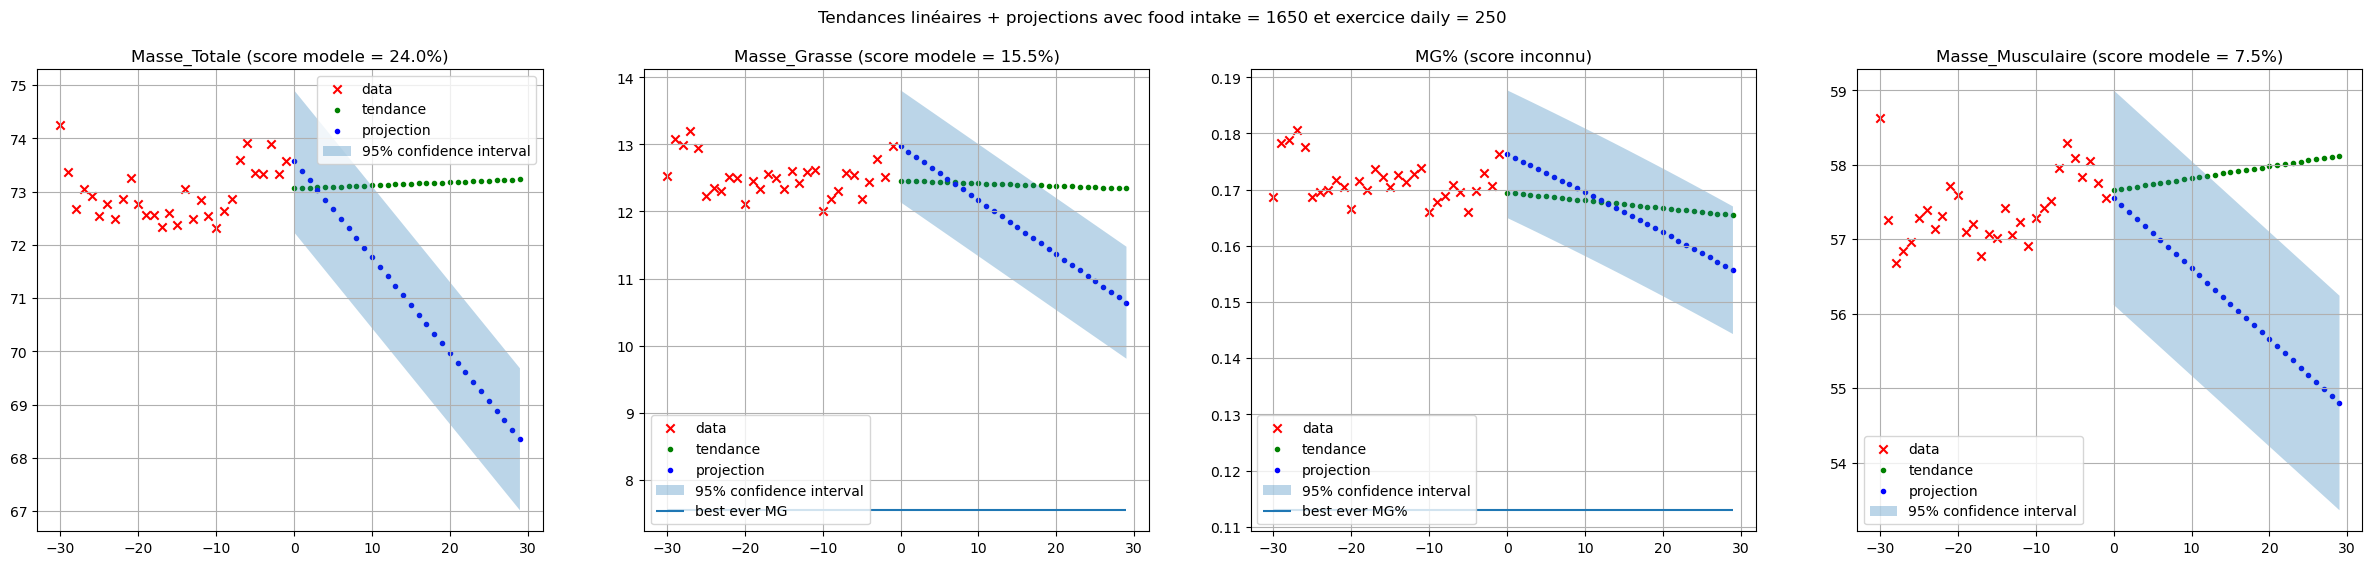

In [64]:
# Indicateurs Masse Totale, Masse Grasse, MG%, Masse Musculaire

X_past = np.array( [i for i in range(-horizon_past,0)] )
X_futur = np.array( [i for i in range(horizon_futur)] )
X = np.array([i for i in range(-horizon_past, horizon_futur)])

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30,6))

for i, name in enumerate(data_columns):
    
    # tendances
    brr = linear_model.BayesianRidge()
    # brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    data_past = df_all[name][-horizon_past:].to_numpy()
    brr.fit( X_past.reshape(-1,1), data_past )
    
    data_futur = brr.predict(X_futur.reshape(-1,1))
    
    std = np.sqrt(1/brr.alpha_)
   
    axs[i].scatter(X_past, data_past, marker='x', color='red', label='data')
    axs[i].scatter(X_futur, data_futur, marker='.', color='green', label='tendance')
    if name=='MG%':
        titre = name + ' (score inconnu)'
    else:
        titre = name + ' (score modele = ' + f'{scores[name]*100:.1f}%)'
    axs[i].set_title(titre)
    axs[i].grid(True)
    
    # predictions avec hypothèses food intake et exercices
    if name=='MG%':
        y_pred_mt = np.array([ df_all['Masse_Totale'][-1] + X_futur * daily_delta['Masse_Totale'] ]).reshape(-1,1)
        y_pred_mg = np.array([ df_all['Masse_Grasse'][-1] + X_futur * daily_delta['Masse_Grasse'] ]).reshape(-1,1)
        y_pred = np.array([ y_pred_mg[j] / y_pred_mt[j] for j in list(X_futur)]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = np.array(noises['Masse_Grasse'] / df_all['Masse_Totale'][-1])  # estime une std sur MG%
    else:
        last_y = data_past[-1]
        dd = daily_delta[name]
        y_pred = np.array([ last_y + X_futur * dd ]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = noises[name]
    
    y_min = np.squeeze(y_pred - 1.96 * y_std)
    y_max = np.squeeze(y_pred + 1.96 * y_std)
    axs[i].fill_between(
        X_futur,
        y_min,
        y_max,
        alpha=0.3,
        label=r"95% confidence interval",
    )
    
    if name=='MG%':
        axs[i].hlines(best_ever_mgp, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG%')
    if name=='Masse_Grasse':
        axs[i].hlines(best_ever_mg, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG')
        
    axs[i].legend()
    
fig.suptitle(f'Tendances linéaires + projections avec food intake = {food_intake:.0f} et exercice daily = {exos_avg:.0f}')

plt.show()

In [65]:
MAX_CAL = 1650.0
PERIODE = 45
n_jours = 15
target = (MAX_CAL*PERIODE - df_food['Calories'][n_jours-PERIODE:].sum())/n_jours
avg = df_food['Calories'][n_jours-PERIODE:].mean()

print(f'Moyenne {PERIODE-n_jours} derniers jours = {avg:.0f} kcals/jour')
print(f'Target quotidienne sur les {n_jours} prochains jours pour tenir {MAX_CAL:.0f} kcals quotidiennes = {target:.0f} kcals/jour')

Moyenne 30 derniers jours = 1721 kcals/jour
Target quotidienne sur les 15 prochains jours pour tenir 1650 kcals quotidiennes = 1508 kcals/jour


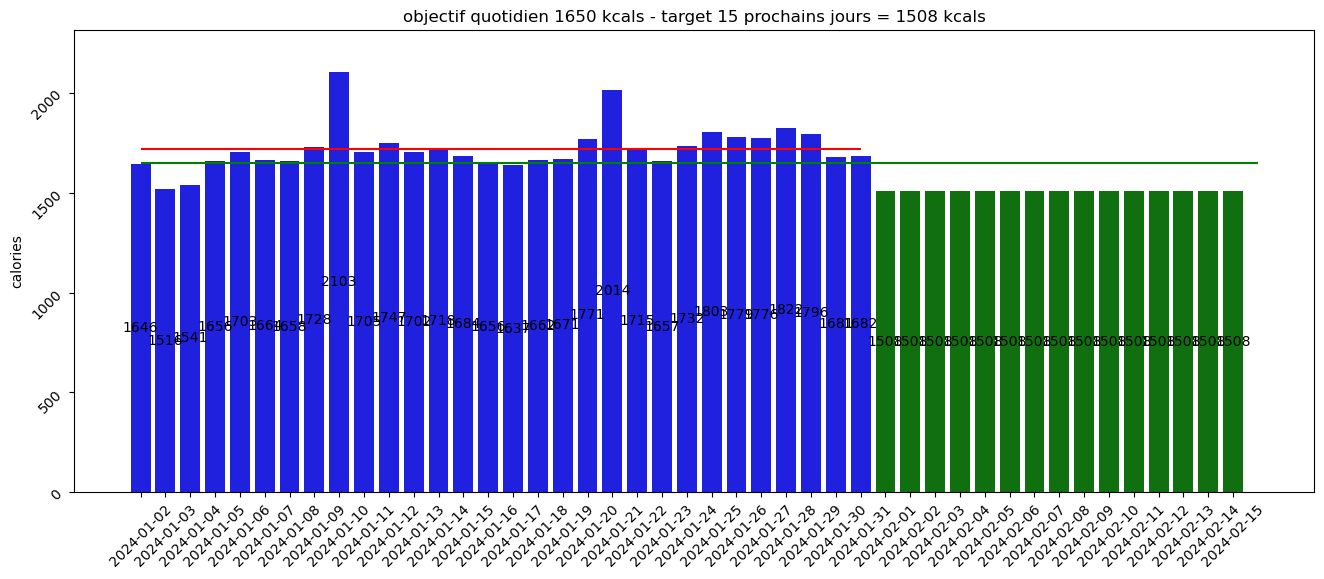

In [66]:
# plot data
fig, ax = plt.subplots(figsize=(16, 6))

tick_label = list(df_food.index[n_jours-PERIODE:]) + [ df_food.index[-1] + datetime.timedelta(days=d) for d in range(1,n_jours+1 )]
listcals = list(df_food['Calories'][n_jours-PERIODE:]) + [ target ] * n_jours

colors = [ 'blue'] * (PERIODE-n_jours) + ['green'] * n_jours
sns.barplot(x=tick_label, y=listcals, ax=ax, palette=colors)

# annotate
ax.bar_label(ax.containers[0], label_type='center', fmt="%.0f")
ax.tick_params(labelrotation=45)

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

ax.set_ylabel('calories')
ax.set_title(f'objectif quotidien {MAX_CAL:.0f} kcals - target {n_jours} prochains jours = {target:.0f} kcals')

ax.hlines(y=avg, xmin=0, xmax=PERIODE-n_jours-1, colors=['red'])
ax.hlines(y=MAX_CAL, xmin=0, xmax=PERIODE, colors=['green'])

plt.show()

# Graphes

In [67]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 'cal_deficit',

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [68]:
def plot_general(longueur=15,
                 year=2023,
                 month=11,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

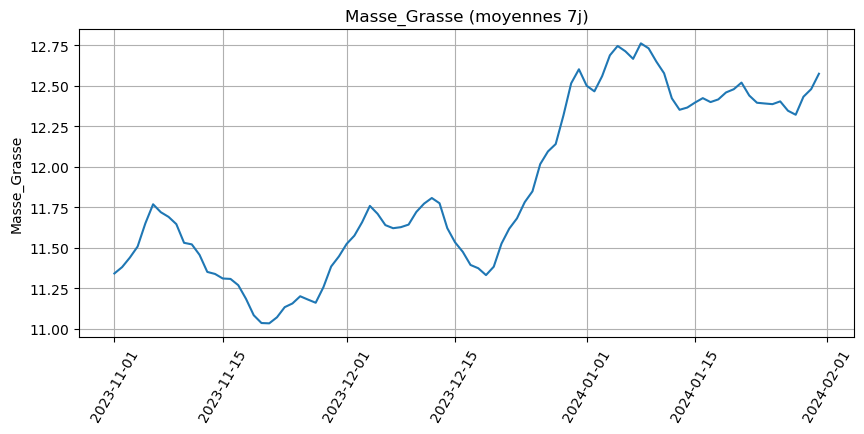

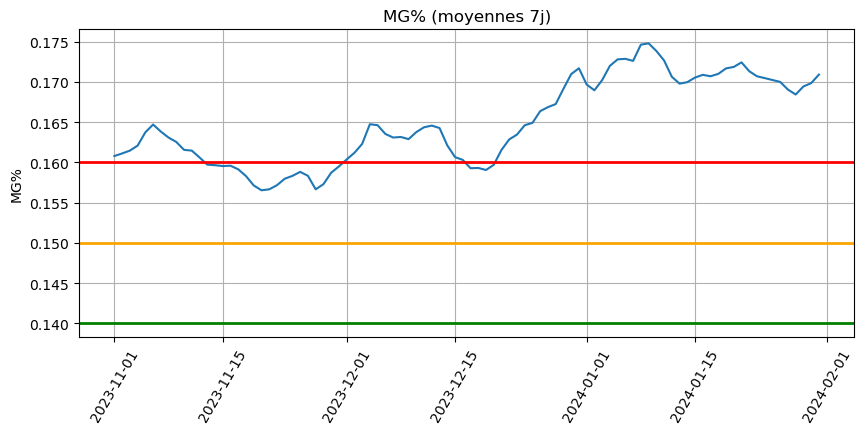

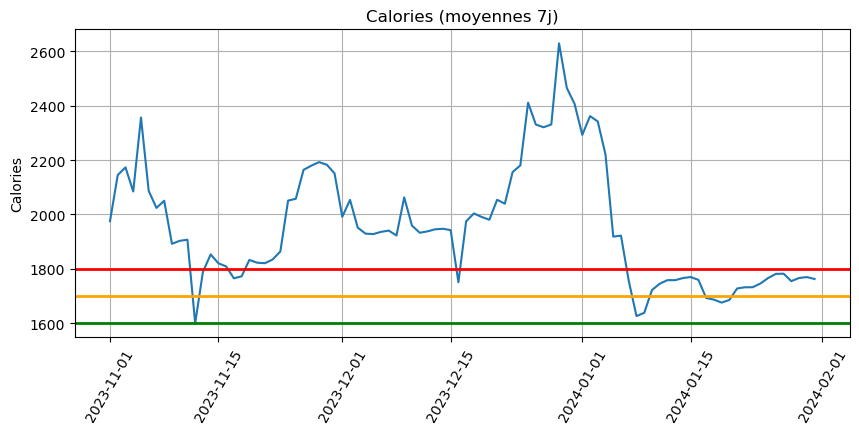

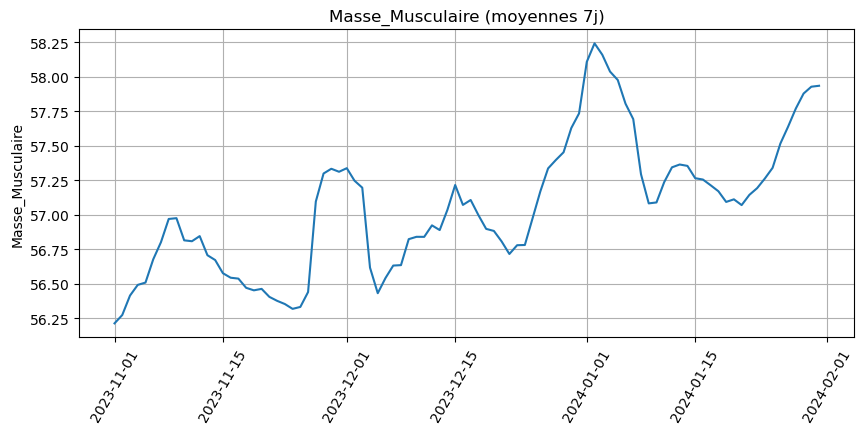

In [69]:
plot_general(longueur=7)

In [70]:
# vars = ['Masse_Grasse', 'MG%', 'Calories','Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire',  'cal_deficit', 

# ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

In [71]:
def plot_general2(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [72]:
# ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [73]:
def plot_general3(longueur=15,
                 year=2023,
                 month=11,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [74]:
# ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [75]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [76]:
# ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [77]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [78]:
# ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [79]:
def scatter_plot3(mass_interval=5.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [80]:
# ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))